In [ ]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import yfinance as yf

# ---------- MACD Functions ----------
def calculate_macd_line(series, window_fast=12, window_slow=26):
    series = pd.Series(series, dtype=float).dropna()
    if series.empty or len(series) < max(window_fast, window_slow):
        return pd.Series(np.nan, index=series.index)
    try:
        exp1 = series.ewm(span=window_fast, adjust=False).mean()
        exp2 = series.ewm(span=window_slow, adjust=False).mean()
        return exp1 - exp2
    except Exception as e:
        print(f"MACD Line Error: {e}")
        return pd.Series(np.nan, index=series.index)

def calculate_macd_signal(series, window_signal=9):
    series = pd.Series(series, dtype=float).dropna()
    if series.empty or len(series) < window_signal:
        return pd.Series(np.nan, index=series.index)
    try:
        return series.ewm(span=window_signal, adjust=False).mean()
    except Exception as e:
        print(f"MACD Signal Error: {e}")
        return pd.Series(np.nan, index=series.index)

# ---------- Adjust yfinance Columns ----------
def adjust_stock_columns(df, ticker):
    df = df.reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
    df.rename(columns={'Date_': 'Date'}, inplace=True)
    df.columns = df.columns.str.replace(f'_{ticker.upper()}', '', regex=False)
    df['Ticker'] = ticker.lower()
    return df

# ---------- Merge Google Drive Data ----------
def process_google_drive_data(ticker):
    try:
        div = pd.read_csv(f"/content/drive/MyDrive/stockproject/{ticker}/div.csv")
        eps = pd.read_csv(f"/content/drive/MyDrive/stockproject/{ticker}/eps.csv")
        pb = pd.read_csv(f"/content/drive/MyDrive/stockproject/{ticker}/pb.csv")
        pe = pd.read_csv(f"/content/drive/MyDrive/stockproject/{ticker}/pe.csv")
    except FileNotFoundError as e:
        print(f"Missing file for {ticker}: {e}")
        return None

    for df_temp in [div, eps, pb, pe]:
        if 'DateTime' in df_temp.columns:
            df_temp['DateTime'] = pd.to_datetime(df_temp['DateTime']).dt.date
            for col in df_temp.columns:
                if ticker.upper().strip(".NS") in col.upper() and col != 'DateTime':
                    df_temp.drop(columns=col, inplace=True)
                    break

    merged_df = div.merge(eps, on='DateTime').merge(pb, on='DateTime').merge(pe, on='DateTime')
    rename_dict = {col: 'Div' if 'Div. Yield' in col else
                        'EPS' if 'EPS' in col else
                        'PB' if 'PB' in col else
                        'PE' if 'PE' in col else
                        'Date' if 'DateTime' in col else col
                   for col in merged_df.columns}
    merged_df.rename(columns=rename_dict, inplace=True)
    merged_df['EPS'] = merged_df['EPS'].ffill()
    merged_df['Div'] = merged_df['Div'].ffill()
    merged_df['PB'] = merged_df['PB'].shift(1)
    merged_df['PE'] = merged_df['PE'].shift(1)
    return merged_df

# ---------- Feature Engineering ----------
def engineer_features(df):
    df = df.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)
    df["Return_1M"] = df.groupby('Ticker')["Close"].pct_change(21).shift(1)
    df["Volatility_1M"] = df.groupby('Ticker')["Close"].rolling(21).std().shift(1).reset_index(level=0, drop=True)
    for window in [20, 50, 100]:
        df[f"SMA_{window}"] = df.groupby('Ticker')["Close"].rolling(window).mean().shift(1).reset_index(level=0, drop=True)

    price_diff = df.groupby('Ticker')["Close"].diff()
    gain = price_diff.clip(lower=0).rolling(14).mean()
    loss = price_diff.clip(upper=0).abs().rolling(14).mean()
    rs = gain / loss
    df["RSI"] = (100 - (100 / (1 + rs))).shift(1)

    for period in [10, 20]:
        df[f"ROC_{period}"] = df.groupby('Ticker')["Close"].pct_change(period).shift(1) * 100

    df['OBV'] = df.groupby('Ticker')["Close"].transform(lambda x: np.sign(x.diff())).shift(1)
    df['OBV'] *= df['Volume'].shift(1)
    df['OBV'] = df.groupby('Ticker')["OBV"].transform(lambda x: x.fillna(0).cumsum())

    df['Dividend_Payout_Ratio'] = (df['Div'] / df['EPS']).replace([np.inf, -np.inf], np.nan).shift(1)
    df["Future_Return_6m"] = df.groupby('Ticker')["Close"].shift(-126) / df["Close"] * 100 - 100
    df["Future_value_6m"] = df.groupby('Ticker')["Close"].shift(-126)

    df["MACD"] = df.groupby("Ticker")["Close"].transform(calculate_macd_line).shift(1)
    df["MACD_Signal"] = df.groupby("Ticker")["MACD"].transform(calculate_macd_signal).shift(1)
    return df

# ---------- Main Pipeline ----------
def build_feature_dataset(tickers):
    all_dfs = []
    for ticker in tickers:
        print(f"Processing {ticker}")
        drive_df = process_google_drive_data(ticker)
        if drive_df is None:
            continue
        end_date = date.today()
        start_date = end_date - timedelta(days=3650)
        yf_df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
        yf_df = adjust_stock_columns(yf_df, ticker)
        yf_df['Date'] = pd.to_datetime(yf_df['Date']).dt.date
        drive_df['Date'] = pd.to_datetime(drive_df['Date']).dt.date
        merged = pd.merge(yf_df, drive_df, on='Date', how='left').fillna(np.nan)
        all_dfs.append(merged)

    df = pd.concat(all_dfs, ignore_index=True)
    df = engineer_features(df)
    return df


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
tickers = ['maruti.ns', 'axisbank.ns', 'reliance.ns', 'bajajfinsv.ns', 'adaniports.ns', 'lt.ns', 'tcs.ns', 'infy.ns','hindunilvr.ns', 'hdfcbank.ns']
df = build_feature_dataset(tickers)
display(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing maruti.ns


[*********************100%***********************]  1 of 1 completed


Processing axisbank.ns


[*********************100%***********************]  1 of 1 completed


Processing reliance.ns


[*********************100%***********************]  1 of 1 completed


Processing bajajfinsv.ns


[*********************100%***********************]  1 of 1 completed


Processing adaniports.ns


[*********************100%***********************]  1 of 1 completed


Processing lt.ns


[*********************100%***********************]  1 of 1 completed


Processing tcs.ns


[*********************100%***********************]  1 of 1 completed


Processing infy.ns


[*********************100%***********************]  1 of 1 completed


Processing hindunilvr.ns


[*********************100%***********************]  1 of 1 completed


Processing hdfcbank.ns


[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume,Ticker,Div,EPS,PB,...,SMA_100,RSI,ROC_10,ROC_20,OBV,Dividend_Payout_Ratio,Future_Return_6m,Future_value_6m,MACD,MACD_Signal
0,2015-11-26,253.892319,258.155436,252.992316,257.208077,5489324,adaniports.ns,NaN,NaN,5.34,...,NaN,NaN,NaN,NaN,0.000000e+00,NaN,-24.172871,192.519257,NaN,NaN
1,2015-11-26,454.042023,457.213389,453.261391,453.846880,26648537,axisbank.ns,NaN,NaN,3.22,...,1410.619999,NaN,NaN,NaN,0.000000e+00,NaN,10.025790,499.563324,0.000000,NaN
2,2015-11-26,196.554398,197.828139,195.410010,197.828139,529200,bajajfinsv.ns,NaN,NaN,2.05,...,1146.906948,NaN,NaN,NaN,0.000000e+00,NaN,-8.847384,179.164474,0.000000,0.000000
3,2015-11-26,244.593002,245.294182,241.638903,243.455051,8791484,hdfcbank.ns,NaN,NaN,6.60,...,2025.189004,NaN,NaN,NaN,0.000000e+00,NaN,10.451615,270.156921,0.000000,0.000000
4,2015-11-26,691.126282,698.824829,687.468414,693.040288,1282221,hindunilvr.ns,NaN,NaN,51.23,...,984.785049,NaN,NaN,NaN,0.000000e+00,NaN,5.255721,727.449951,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24685,2025-11-21,1545.000000,1551.500000,1526.300049,1531.000000,9186302,infy.ns,NaN,NaN,NaN,...,1490.470022,62.756159,0.816071,-2.526171,-1.836248e+08,NaN,NaN,NaN,-20.836697,2.960446
24686,2025-11-21,4024.899902,4057.000000,4015.199951,4026.000000,1241149,lt.ns,NaN,NaN,NaN,...,3696.559006,61.817062,4.618090,2.835462,8.604194e+08,NaN,NaN,NaN,15.881922,-24.770211
24687,2025-11-21,15977.000000,16150.000000,15737.000000,15790.000000,586351,maruti.ns,NaN,NaN,NaN,...,14541.631934,50.264973,3.667737,3.073062,4.373200e+08,NaN,NaN,NaN,54.437473,12.689370
24688,2025-11-21,1546.599976,1557.800049,1540.099976,1541.000000,9615271,reliance.ns,NaN,NaN,NaN,...,1428.495619,71.507759,3.217262,-1.824997,6.053614e+07,NaN,NaN,NaN,-15.943955,55.088353


In [ ]:
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Value counts where volume is 0
volume_zero_counts = df[df['Volume'] == 0]['Volume'].value_counts()
display(volume_zero_counts)

,count
Volume,
0,20


In [ ]:
df = df[df['Volume'] != 0]

In [ ]:
# Multi-class target
def classify_movement(x):
    if x >= 0:
        return "Up"
    elif x < -0:
        return "Down"


df["Target_6m_multi"] = df["Future_Return_6m"].apply(classify_movement)

# Save full version before dropping
df_with_future_values = df.copy()

/tmp/ipython-input-2439882649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Target_6m_multi"] = df["Future_Return_6m"].apply(classify_movement)


In [ ]:
df

,Date,Close,High,Low,Open,Volume,Ticker,Div,EPS,PB,...,RSI,ROC_10,ROC_20,OBV,Dividend_Payout_Ratio,Future_Return_6m,Future_value_6m,MACD,MACD_Signal,Target_6m_multi
0,2015-11-26,253.892319,258.155436,252.992316,257.208077,5489324,adaniports.ns,NaN,NaN,5.34,...,NaN,NaN,NaN,0.000000e+00,NaN,-24.172871,192.519257,NaN,NaN,Down
1,2015-11-26,454.042023,457.213389,453.261391,453.846880,26648537,axisbank.ns,NaN,NaN,3.22,...,NaN,NaN,NaN,0.000000e+00,NaN,10.025790,499.563324,0.000000,NaN,Up
2,2015-11-26,196.554398,197.828139,195.410010,197.828139,529200,bajajfinsv.ns,NaN,NaN,2.05,...,NaN,NaN,NaN,0.000000e+00,NaN,-8.847384,179.164474,0.000000,0.000000,Down
3,2015-11-26,244.593002,245.294182,241.638903,243.455051,8791484,hdfcbank.ns,NaN,NaN,6.60,...,NaN,NaN,NaN,0.000000e+00,NaN,10.451615,270.156921,0.000000,0.000000,Up
4,2015-11-26,691.126282,698.824829,687.468414,693.040288,1282221,hindunilvr.ns,NaN,NaN,51.23,...,NaN,NaN,NaN,0.000000e+00,NaN,5.255721,727.449951,0.000000,0.000000,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24685,2025-11-21,1545.000000,1551.500000,1526.300049,1531.000000,9186302,infy.ns,NaN,NaN,NaN,...,62.756159,0.816071,-2.526171,-1.836248e+08,NaN,NaN,NaN,-20.836697,2.960446,None
24686,2025-11-21,4024.899902,4057.000000,4015.199951,4026.000000,1241149,lt.ns,NaN,NaN,NaN,...,61.817062,4.618090,2.835462,8.604194e+08,NaN,NaN,NaN,15.881922,-24.770211,None
24687,2025-11-21,15977.000000,16150.000000,15737.000000,15790.000000,586351,maruti.ns,NaN,NaN,NaN,...,50.264973,3.667737,3.073062,4.373200e+08,NaN,NaN,NaN,54.437473,12.689370,None
24688,2025-11-21,1546.599976,1557.800049,1540.099976,1541.000000,9615271,reliance.ns,NaN,NaN,NaN,...,71.507759,3.217262,-1.824997,6.053614e+07,NaN,NaN,NaN,-15.943955,55.088353,None


In [ ]:
df["Target_6m_multi"].value_counts()

,count
Target_6m_multi,
Up,16688
Down,6732


In [ ]:
# Find the earliest date where 'Target_6m_multi' is null
null_future_value_dates = df_with_future_values[df_with_future_values['Target_6m_multi'].isnull()]['Date'].sort_values()

if not null_future_value_dates.empty:
    earliest_null_date = null_future_value_dates.iloc[0]
    print(f"The earliest date with a null 'Target_6m_multi' is: {earliest_null_date}")
else:
    print("There are no null values in the 'Target_6m_multi' column.")

The earliest date with a null 'Target_6m_multi' is: 2025-05-26 00:00:00


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0
Ticker,0
Div,0
EPS,0
PB,0


In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 17148 entries, 1000 to 23429
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   17148 non-null  datetime64[ns]
 1   Close                  17148 non-null  float64       
 2   High                   17148 non-null  float64       
 3   Low                    17148 non-null  float64       
 4   Open                   17148 non-null  float64       
 5   Volume                 17148 non-null  int64         
 6   Ticker                 17148 non-null  object        
 7   Div                    17148 non-null  float64       
 8   EPS                    17148 non-null  float64       
 9   PB                     17148 non-null  float64       
 10  PE                     17148 non-null  float64       
 11  Return_1M              17148 non-null  float64       
 12  Volatility_1M          17148 non-null  float64       
 13  SMA

None

In [ ]:
features = ['Ticker','Volume', 'Div', 'EPS', 'PB', 'PE','SMA_50','SMA_100', 'Return_1M', 'Volatility_1M', 'RSI', 'OBV', 'MACD_Signal','MACD','ROC_20','ROC_10']
target = 'Target_6m_multi'
df = df[df['Date']<'2024-12-31']
X = df[features]
y = df[target]

# One-hot encode the 'Ticker' column
X = pd.get_dummies(X, columns=['Ticker'], drop_first=True)


# Time-based split
split_date_train = pd.to_datetime("2022-12-31")
X_train = X[df["Date"] <= split_date_train]
X_test = X[df["Date"] > split_date_train]
y_train = y[df["Date"] <= split_date_train]
y_test = y[df["Date"] > split_date_train]

In [ ]:
df_prediction = df_with_future_values[(df_with_future_values['Date'] > pd.to_datetime('2024-12-31')) & (df_with_future_values['Date'] <= pd.to_datetime('2025-05-09'))].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# Logistic Regression model
model = LogisticRegression(random_state=42, solver='liblinear') # Added solver for smaller datasets/backward compatibility
model.fit(X_train, y_train_encoded)
y_pred = model.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test_encoded, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

# Initialize and train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=20)
dt_model.fit(X_train, y_train_encoded)
y_pred_dt = dt_model.predict(X_test)
print("\nDecision Tree:")
print(classification_report(y_test_encoded, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_dt))

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train_encoded)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test_encoded, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_rf))

# Initialize and train XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # Added eval_metric
xgb_model.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_xgb))

from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize the model
hgb_model = HistGradientBoostingClassifier(
    max_iter=200,            # Number of boosting iterations (trees)
    learning_rate=0.1,       # Shrinkage rate
    max_depth=7,             # Maximum depth of each tree
    l2_regularization=1.0,   # Regularization strength
    early_stopping=True,     # Enable early stopping
    random_state=42
)

# Fit the model
hgb_model.fit(X_train, y_train_encoded)

# Predict
y_pred_hgb = hgb_model.predict(X_test)

# Evaluate
print("\nHistGradientBoosting:")
print(classification_report(y_test_encoded, y_pred_hgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_hgb))

# Initialize and train KNeighborsClassifier model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train_encoded)
y_pred_knn = knn_model.predict(X_test)
print("\nKNeighborsClassifier:")
print(classification_report(y_test_encoded, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_knn))

# Initialize and train SVC model
# SVC can be computationally expensive and sensitive to feature scaling.
# For demonstration, using default parameters, but scaling is often needed for better results.
svc_model = SVC(random_state=42) # Added random_state
svc_model.fit(X_train, y_train_encoded)
y_pred_svc = svc_model.predict(X_test)
print("\nSVC:")
print(classification_report(y_test_encoded, y_pred_svc))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_svc))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1494
           1       0.70      1.00      0.82      3406

    accuracy                           0.70      4900
   macro avg       0.85      0.50      0.41      4900
weighted avg       0.79      0.70      0.57      4900

Confusion Matrix:
[[   1 1493]
 [   0 3406]]

Decision Tree:
              precision    recall  f1-score   support

           0       0.42      0.58      0.49      1494
           1       0.78      0.65      0.71      3406

    accuracy                           0.63      4900
   macro avg       0.60      0.61      0.60      4900
weighted avg       0.67      0.63      0.64      4900

Confusion Matrix:
[[ 866  628]
 [1206 2200]]

Random Forest:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41      1494
           1       0.74      0.72      0.73      3406

    accuracy                           

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:26:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost:
              precision    recall  f1-score   support

           0       0.41      0.31      0.35      1494
           1       0.73      0.81      0.76      3406

    accuracy                           0.65      4900
   macro avg       0.57      0.56      0.56      4900
weighted avg       0.63      0.65      0.64      4900

Confusion Matrix:
[[ 461 1033]
 [ 659 2747]]

HistGradientBoosting:
              precision    recall  f1-score   support

           0       0.37      0.33      0.35      1494
           1       0.72      0.75      0.73      3406

    accuracy                           0.62      4900
   macro avg       0.54      0.54      0.54      4900
weighted avg       0.61      0.62      0.62      4900

Confusion Matrix:
[[ 500  994]
 [ 858 2548]]

KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.28      0.29      0.29      1494
           1       0.68      0.67      0.68      3406

    accuracy                        

In [ ]:
# Find the last available date in df_with_future_values
last_available_date = df_with_future_values['Date'].max()

# Create a DataFrame for the prediction period (2025-05-09 till the last available date)
df_prediction_future = df_with_future_values[(df_with_future_values['Date'] > pd.to_datetime('2025-05-09')) & (df_with_future_values['Date'] <= last_available_date)].copy()

# Select the same features used for training
X_future = df_prediction_future[features]

# One-hot encode the 'Ticker' column in the future data, aligning with the training data columns
X_future = pd.get_dummies(X_future, columns=['Ticker'], drop_first=True)

# Reindex X_future to match the columns of X_train, filling missing columns with 0
X_future = X_future.reindex(columns=X_train.columns, fill_value=0)

# Make predictions using the trained Decision Tree model
future_predictions_dt_extended = dt_model.predict(X_future)

# Add the predictions to the df_prediction_future DataFrame
df_prediction_future['Predicted_Target_6m_multi_DT'] = le.inverse_transform(future_predictions_dt_extended)

# Display the DataFrame with predictions
display(df_prediction_future[['Date', 'Ticker', 'Predicted_Target_6m_multi_DT']])

,Date,Ticker,Predicted_Target_6m_multi_DT
23330,2025-05-12,adaniports.ns,Up
23331,2025-05-12,axisbank.ns,Up
23332,2025-05-12,bajajfinsv.ns,Down
23333,2025-05-12,hdfcbank.ns,Up
23334,2025-05-12,hindunilvr.ns,Down
...,...,...,...
24685,2025-11-21,infy.ns,Up
24686,2025-11-21,lt.ns,Up
24687,2025-11-21,maruti.ns,Down
24688,2025-11-21,reliance.ns,Up


In [ ]:
# Replace 'your_ticker_here' with the ticker you want to see predictions for
ticker_to_display = 'bajajfinsv.ns' # Example ticker

# Filter the original future prediction DataFrame for the selected ticker
df_prediction_ticker = df_prediction_future[df_prediction_future['Ticker'] == ticker_to_display].copy()

# Select the same features used for training for the filtered data
X_future_ticker = df_prediction_ticker[features]

# One-hot encode the 'Ticker' column in the filtered future data, aligning with the training data columns
X_future_ticker = pd.get_dummies(X_future_ticker, columns=['Ticker'], drop_first=True)

# Reindex X_future_ticker to match the columns of X_train, filling missing columns with 0
X_future_ticker = X_future_ticker.reindex(columns=X_train.columns, fill_value=0)

# Get the prediction probabilities for the filtered data
future_probabilities_dt_extended = dt_model.predict_proba(X_future_ticker)

# Add the probabilities to the filtered DataFrame
# Assuming 'Down' is class 0 and 'Up' is class 1 based on LabelEncoder output
df_prediction_ticker['Probability_Down'] = future_probabilities_dt_extended[:, le.transform(['Down'])[0]]
df_prediction_ticker['Probability_Up'] = future_probabilities_dt_extended[:, le.transform(['Up'])[0]]


# Sort by date and display the latest predictions with probabilities
latest_predictions = df_prediction_ticker.sort_values(by='Date', ascending=False)

print(f"Latest predictions and probabilities for {ticker_to_display}:")
display(latest_predictions[['Date', 'Ticker', 'Predicted_Target_6m_multi_DT', 'Probability_Down', 'Probability_Up']].head())

Latest predictions and probabilities for bajajfinsv.ns:


,Date,Ticker,Predicted_Target_6m_multi_DT,Probability_Down,Probability_Up
24682,2025-11-21,bajajfinsv.ns,Up,0.435352,0.564648
24672,2025-11-20,bajajfinsv.ns,Up,0.435352,0.564648
24662,2025-11-19,bajajfinsv.ns,Up,0.435352,0.564648
24652,2025-11-18,bajajfinsv.ns,Up,0.435352,0.564648
24642,2025-11-17,bajajfinsv.ns,Up,0.435352,0.564648


## Define a function to process, evaluate, and predict

### Subtask:
Create a new function that takes a list of tickers as input and encapsulates the logic from the previous steps.


**Reasoning**:
Define the function `process_evaluate_predict` that encapsulates the data processing, evaluation, and prediction steps for a list of tickers.



In [ ]:
def process_evaluate_predict(tickers_list):
    """
    Processes data for a list of tickers, evaluates a pre-trained Decision Tree
    model on a specified evaluation period, and predicts future stock movements
    with probabilities for each ticker.

    Args:
        tickers_list (list): A list of stock ticker symbols.
    """
    # Build feature dataset for new tickers
    print("Building feature dataset for new tickers...")
    df_new_tickers = build_feature_dataset(tickers_list)

    # Calculate 'Future_Return_6m' and 'Target_6m_multi' for df_new_tickers
    df_new_tickers["Future_Return_6m"] = df_new_tickers.groupby('Ticker')["Close"].shift(-126) / df_new_tickers["Close"] * 100 - 100
    df_new_tickers["Target_6m_multi"] = df_new_tickers["Future_Return_6m"].apply(classify_movement)

    # Convert 'Date' column to datetime objects
    df_new_tickers['Date'] = pd.to_datetime(df_new_tickers['Date'])

    # Prepare data for evaluation
    print("\nPreparing data for evaluation...")
    # Define the start date for the evaluation period
    eval_start_date = pd.to_datetime("2025-01-01")

    # Identify the earliest date where 'Target_6m_multi' is null in the original df_with_future_values
    # This date was already identified in a previous cell and stored in earliest_null_date
    # We use this variable directly.

    # Filter df_new_tickers for the evaluation period
    df_eval = df_new_tickers[(df_new_tickers['Date'] >= eval_start_date) & (df_new_tickers['Date'] < earliest_null_date)].copy()

    if df_eval.empty:
        print(f"No evaluation data available for tickers: {tickers_list} in the period {eval_start_date.date()} to {earliest_null_date.date()}. Skipping evaluation and future prediction.")
        return


    # Create the feature set X_eval
    X_eval = df_eval[features].copy()

    # Create the target set y_eval
    y_eval = df_eval[target].copy()

    # One-hot encode the 'Ticker' column in X_eval, aligning with X_train
    X_eval = pd.get_dummies(X_eval, columns=['Ticker'], drop_first=True)
    X_eval = X_eval.reindex(columns=X_train.columns, fill_value=0)

    # Encode the y_eval target variable
    y_eval_encoded = le.transform(y_eval)

    # Make predictions for evaluation period
    print("\nMaking predictions for evaluation period...")
    y_pred_eval = dt_model.predict(X_eval)

    # Evaluate decision tree performance
    print("\nEvaluating Decision Tree Performance on Evaluation Data:")
    # Get unique tickers in the evaluation DataFrame
    unique_tickers_eval = df_eval['Ticker'].unique()

    for ticker in unique_tickers_eval:
        print(f"\nPerformance for {ticker}:")

        # Get the indices for the current ticker in the evaluation DataFrame
        ticker_indices = df_eval[df_eval['Ticker'] == ticker].index

        # Filter actual and predicted values for the current ticker using indices
        y_eval_ticker_encoded = y_eval_encoded[df_eval.index.isin(ticker_indices)]
        y_pred_eval_ticker = y_pred_eval[df_eval.index.isin(ticker_indices)]

        if y_eval_ticker_encoded.size == 0:
             print(f"No evaluation data for {ticker}.")
             continue


        # Display classification report and confusion matrix for the current ticker
        # Check if there is more than one class in y_eval_ticker_encoded
        if len(np.unique(y_eval_ticker_encoded)) > 1:
            print(classification_report(y_eval_ticker_encoded, y_pred_eval_ticker))
            print("Confusion Matrix:")
            print(confusion_matrix(y_eval_ticker_encoded, y_pred_eval_ticker))
        else:
            print("Only one class present in actual data for this ticker. Cannot compute full classification report.")
            print(f"Accuracy: {accuracy_score(y_eval_ticker_encoded, y_pred_eval_ticker)}")
            print("Confusion Matrix:")
            print(confusion_matrix(y_eval_ticker_encoded, y_pred_eval_ticker))


        # Display actual vs predicted values in a table
        print("\nActual vs Predicted Values (Evaluation Period):")
        actual_vs_predicted_df = pd.DataFrame({
            'Date': df_eval.loc[ticker_indices, 'Date'],
            'Ticker': ticker,
            'Actual': le.inverse_transform(y_eval_ticker_encoded),
            'Predicted': le.inverse_transform(y_pred_eval_ticker)
        })
        display(actual_vs_predicted_df.sort_values(by='Date'))

        # Plot Predictions vs. Actuals for the current ticker
        print(f"\nPlotting Actual vs. Predicted for {ticker} (Evaluation Period):")

        # Map 'Up' and 'Down' to numerical values for plotting
        plot_df = actual_vs_predicted_df.copy()
        plot_df['Actual_Numeric'] = plot_df['Actual'].apply(lambda x: 1 if x == 'Up' else 0)
        plot_df['Predicted_Numeric'] = plot_df['Predicted'].apply(lambda x: 1 if x == 'Up' else 0)

        # Add a small vertical offset to predicted 'Up' points when they overlap with actual 'Up' points
        plot_df['Predicted_Numeric_Offset'] = plot_df['Predicted_Numeric']
        offset_amount = 0.05  # Adjust this value as needed
        plot_df.loc[(plot_df['Actual_Numeric'] == 1) & (plot_df['Predicted_Numeric'] == 1), 'Predicted_Numeric_Offset'] = 1 + offset_amount

        # Add a small vertical offset to predicted 'Down' points when they overlap with actual 'Down' points
        plot_df.loc[(plot_df['Actual_Numeric'] == 0) & (plot_df['Predicted_Numeric'] == 0), 'Predicted_Numeric_Offset'] = 0 - offset_amount


        # Create the plot
        plt.figure(figsize=(14, 7))
        plt.scatter(plot_df['Date'], plot_df['Actual_Numeric'], color='blue', label='Actual', alpha=0.6)
        plt.scatter(plot_df['Date'], plot_df['Predicted_Numeric_Offset'], color='red', label='Predicted', alpha=0.6)

        # Customize the plot
        plt.title(f'Actual vs. Predicted Stock Movement for {ticker} (Evaluation Period)')
        plt.xlabel('Date')
        plt.ylabel('Movement (0: Down, 1: Up)')
        plt.yticks([-offset_amount, 0, 1, 1 + offset_amount], ['Down (Predicted)', 'Down (Actual)', 'Up (Actual)', 'Up (Predicted)']) # Update y-ticks for clarity
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Show the plot
        plt.show()


    # Prepare data for future prediction
    print("\nPreparing data for future prediction...")
    # Define the start date for future prediction as the earliest date where 'Target_6m_multi' is null
    # This date is already stored in the earliest_null_date variable.

    # Define the end date for future prediction as the last available date in the df_new_tickers DataFrame.
    end_date_future = df_new_tickers['Date'].max()

    # Filter the df_new_tickers DataFrame to include data from the start date for future prediction up to the end date for future prediction.
    df_future_new_tickers = df_new_tickers[(df_new_tickers['Date'] >= earliest_null_date) & (df_new_tickers['Date'] <= end_date_future)].copy()

    if df_future_new_tickers.empty:
        print(f"No future prediction data available for tickers: {tickers_list} from {earliest_null_date.date()} to {end_date_future.date()}. Skipping future prediction.")
        return

    # Select the features from the df_future_new_tickers DataFrame that were used for training the model.
    X_future_new_tickers = df_future_new_tickers[features].copy()

    # One-hot encode the 'Ticker' column in the X_future_new_tickers DataFrame, aligning with the columns in the X_train DataFrame.
    X_future_new_tickers = pd.get_dummies(X_future_new_tickers, columns=['Ticker'], drop_first=True)
    X_future_new_tickers = X_future_new_tickers.reindex(columns=X_train.columns, fill_value=0)

    # Make future predictions
    print("\nMaking future predictions...")
    # Use the trained Decision Tree model to make predictions on the future data for the new tickers
    future_predictions_new_tickers_encoded = dt_model.predict(X_future_new_tickers)

    # Convert the encoded predictions back to their original labels ('Up' or 'Down')
    future_predictions_new_tickers = le.inverse_transform(future_predictions_new_tickers_encoded)

    # Display future predictions
    print("\nDisplaying future predictions:")
    # Add the future_predictions_new_tickers array as a new column
    df_future_new_tickers['Predicted_Target_6m_multi_DT'] = future_predictions_new_tickers

    # Get the prediction probabilities for the future data
    future_probabilities_new_tickers = dt_model.predict_proba(X_future_new_tickers)

    # Add the probabilities to the future predictions DataFrame
    # Assuming 'Down' is class 0 and 'Up' is class 1 based on LabelEncoder output
    df_future_new_tickers['Probability_Down'] = future_probabilities_new_tickers[:, le.transform(['Down'])[0]]
    df_future_new_tickers['Probability_Up'] = future_probabilities_new_tickers[:, le.transform(['Up'])[0]]

    # Get unique tickers in the future predictions DataFrame
    unique_tickers_future = df_future_new_tickers['Ticker'].unique()

    # Display predictions for each ticker, showing only the last 5 days with probabilities
    for ticker in unique_tickers_future:
        print(f"\nLatest 5 future predictions and probabilities for {ticker}:")
        latest_predictions = df_future_new_tickers[df_future_new_tickers['Ticker'] == ticker].sort_values(by='Date', ascending=False)
        display(latest_predictions[['Date', 'Ticker', 'Predicted_Target_6m_multi_DT', 'Probability_Down', 'Probability_Up']].head())


## Call the new function

### Subtask:
Call the newly created function with the `new_tickers` list to execute the consolidated process.


**Reasoning**:
Call the newly created function with the new_tickers list to execute the consolidated process.



Building feature dataset for new tickers...
Processing kotakbank.ns
Missing file for kotakbank.ns: [Errno 2] No such file or directory: '/content/drive/MyDrive/stockproject/kotakbank.ns/div.csv'
Processing reliance.ns


[*********************100%***********************]  1 of 1 completed


Preparing data for evaluation...

Making predictions for evaluation period...

Evaluating Decision Tree Performance on Evaluation Data:

Performance for reliance.ns:
Only one class present in actual data for this ticker. Cannot compute full classification report.
Accuracy: 1.0
Confusion Matrix:
[[97]]

Actual vs Predicted Values (Evaluation Period):



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


,Date,Ticker,Actual,Predicted
2246,2025-01-01,reliance.ns,Up,Up
2247,2025-01-02,reliance.ns,Up,Up
2248,2025-01-03,reliance.ns,Up,Up
2249,2025-01-06,reliance.ns,Up,Up
2250,2025-01-07,reliance.ns,Up,Up
...,...,...,...,...
2338,2025-05-19,reliance.ns,Up,Up
2339,2025-05-20,reliance.ns,Up,Up
2340,2025-05-21,reliance.ns,Up,Up
2341,2025-05-22,reliance.ns,Up,Up


/tmp/ipython-input-3665278976.py:109: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[(plot_df['Actual_Numeric'] == 1) & (plot_df['Predicted_Numeric'] == 1), 'Predicted_Numeric_Offset'] = 1 + offset_amount



Plotting Actual vs. Predicted for reliance.ns (Evaluation Period):


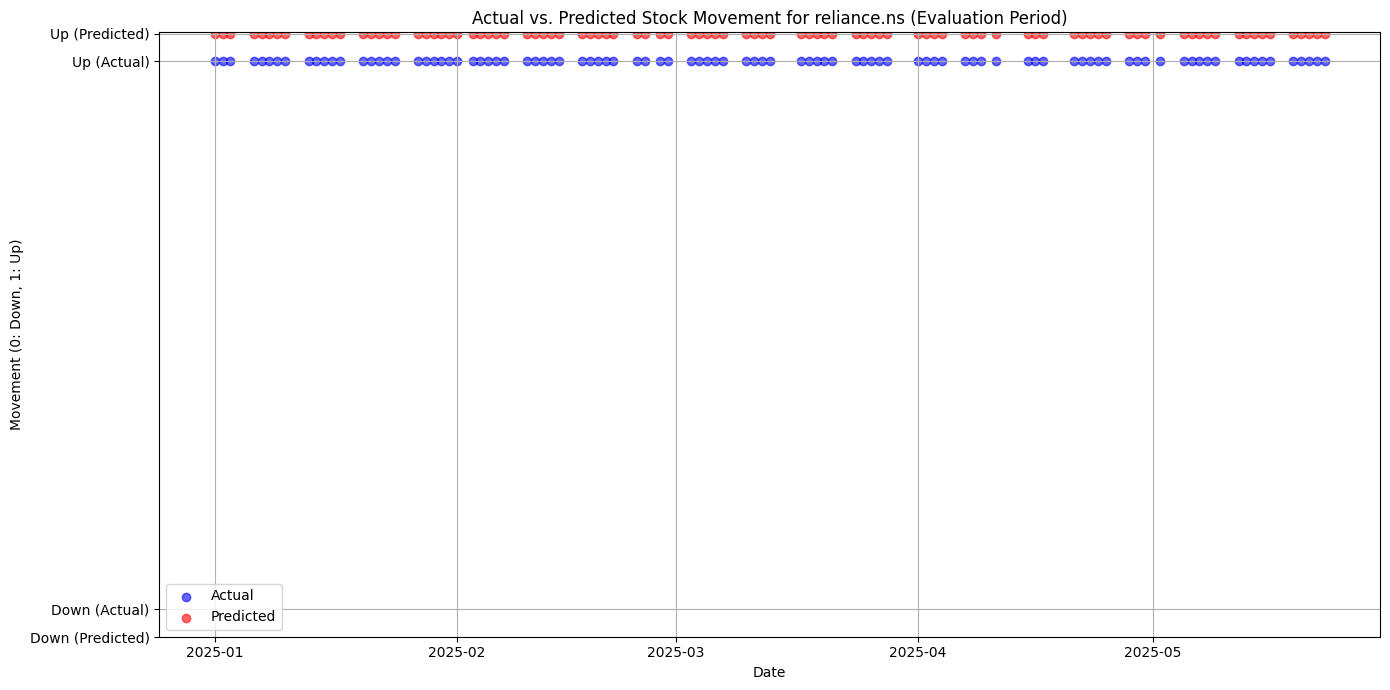


Preparing data for future prediction...

Making future predictions...

Displaying future predictions:

Latest 5 future predictions and probabilities for reliance.ns:


,Date,Ticker,Predicted_Target_6m_multi_DT,Probability_Down,Probability_Up
2468,2025-11-21,reliance.ns,Up,0.435352,0.564648
2467,2025-11-20,reliance.ns,Up,0.435352,0.564648
2466,2025-11-19,reliance.ns,Up,0.435352,0.564648
2465,2025-11-18,reliance.ns,Up,0.435352,0.564648
2464,2025-11-17,reliance.ns,Up,0.435352,0.564648


In [ ]:
new_tickers = ['kotakbank.ns', 'reliance.ns']
process_evaluate_predict(new_tickers)

In [ ]:
import os
!pip install streamlit pyngrok -q

# Get NGROK_AUTH_TOKEN from environment variables or Colab secrets
NGROK_AUTH_TOKEN = os.environ.get("NGROK_AUTH_TOKEN", "")

# If NGROK_AUTH_TOKEN is empty, it means it's not set in environment variables.
# In a Colab environment, it's typically fetched from user data secrets.
# The agent can access it as a variable from the previous steps, but for robustness,
# it's good to ensure it's loaded if the notebook session resets or is run out of order.
# For this specific scenario, we already have `NGROK_AUTH_TOKEN` available in the kernel state.
# No need to re-fetch if it's already there and populated.

# Authenticate ngrok
!ngrok authtoken $NGROK_AUTH_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Run Streamlit app and expose it via ngrok
from pyngrok import ngrok
import subprocess
import threading
import time

# Terminate any previous ngrok tunnels
ngrok.kill()

# Define the path to your Streamlit app
app_path = '/content/drive/MyDrive/stockproject/app.py'

def run_streamlit():
    # Use subprocess.run to avoid blocking the cell indefinitely
    # We don't want to capture output here, just let Streamlit run
    subprocess.run(["streamlit", "run", app_path, "--server.port", "8501", "--server.enableCORS", "false", "--server.enableXsrfProtection", "false"])

# Start Streamlit in a separate thread
print("Starting Streamlit app in a background thread...")
streamlit_thread = threading.Thread(target=run_streamlit)
streamlit_thread.daemon = True # Allow the main program to exit even if thread is running
streamlit_thread.start()

# Give Streamlit a moment to start up
time.sleep(5)

# Open a ngrok tunnel to the Streamlit port
print("Opening ngrok tunnel...")
public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")

Starting Streamlit app in a background thread...
Opening ngrok tunnel...
Streamlit App URL: NgrokTunnel: "https://unalternating-finley-ruminantly.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
# Calculate and save feature means from X_train for imputation
# Exclude ticker dummy variables when calculating means as they are handled separately
# by the get_dummies and reindex process for new tickers.

# Get the list of actual numerical features (excluding one-hot encoded 'Ticker' columns)
# from original_features_list

# original_features_list is defined as ['Volume', 'Div', 'EPS', 'PB', 'PE','SMA_50','SMA_100', 'Return_1M', 'Volatility_1M', 'RSI', 'OBV', 'MACD_Signal','MACD','ROC_20','ROC_10']
# X_train already has these columns along with 'Ticker_' columns

# Calculate means only for the original numerical features
feature_means = X_train[original_features_list].mean()

# Save these means for use in the Streamlit app
joblib.dump(feature_means, model_save_dir + 'feature_means.joblib')
print(f"Feature means saved to {model_save_dir}feature_means.joblib")

Feature means saved to /content/drive/MyDrive/stockproject/feature_means.joblib


In [ ]:
# Define the actual features used for training, excluding 'Ticker' for dummy encoding
original_features_list = ['Volume', 'Div', 'EPS', 'PB', 'PE','SMA_50','SMA_100', 'Return_1M', 'Volatility_1M', 'RSI', 'OBV', 'MACD_Signal','MACD','ROC_20','ROC_10']

model_save_dir = '/content/drive/MyDrive/stockproject/'

In [ ]:
# Define the actual features used for training, excluding 'Ticker' for dummy encoding
original_features_list = ['Volume', 'Div', 'EPS', 'PB', 'PE','SMA_50','SMA_100', 'Return_1M', 'Volatility_1M', 'RSI', 'OBV', 'MACD_Signal','MACD','ROC_20','ROC_10']

model_save_dir = '/content/drive/MyDrive/stockproject/'

In [ ]:
%%writefile /content/drive/MyDrive/stockproject/app.py

# --- Imports ---
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder

# --- Helper Functions (Copied from previous cells) ---

def calculate_macd_line(series, window_fast=12, window_slow=26):
    series = pd.Series(series, dtype=float).dropna()
    if series.empty or len(series) < max(window_fast, window_slow):
        return pd.Series(np.nan, index=series.index)
    try:
        exp1 = series.ewm(span=window_fast, adjust=False).mean()
        exp2 = series.ewm(span=window_slow, adjust=False).mean()
        return exp1 - exp2
    except Exception as e:
        # print(f"MACD Line Error: {e}") # Commented out for Streamlit to avoid verbose output
        return pd.Series(np.nan, index=series.index)

def calculate_macd_signal(series, window_signal=9):
    series = pd.Series(series, dtype=float).dropna()
    if series.empty or len(series) < window_signal:
        return pd.Series(np.nan, index=series.index)
    try:
        return series.ewm(span=window_signal, adjust=False).mean()
    except Exception as e:
        # print(f"MACD Signal Error: {e}") # Commented out for Streamlit
        return pd.Series(np.nan, index=series.index)

def adjust_stock_columns(df, ticker):
    df = df.reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
    df.rename(columns={'Date_': 'Date'}, inplace=True)
    df.columns = df.columns.str.replace(f'_{ticker.upper()}', '', regex=False)
    df['Ticker'] = ticker.lower()
    return df

def process_google_drive_data(ticker):
    base_dir = '/content/drive/MyDrive/stockproject/'

    # Initialize with an empty DataFrame that has a 'Date' column for consistent merging
    final_merged_df = pd.DataFrame({'Date': pd.to_datetime([], unit='ns')})

    metric_configs = {
        'div': {'search_phrases': ['Div. Yield', 'Dividend'], 'col_name': 'Div'},
        'eps': {'search_phrases': ['EPS'], 'col_name': 'EPS'},
        'pb':  {'search_phrases': ['PB', 'Price to Book'], 'col_name': 'PB'},
        'pe':  {'search_phrases': ['PE', 'Price to Earnings'], 'col_name': 'PE'}
    }

    for file_prefix, config in metric_configs.items():
        file_path = f"{base_dir}{ticker}/{file_prefix}.csv"
        target_metric_name = config['col_name']
        temp_metric_df = pd.DataFrame()

        try:
            df_from_file = pd.read_csv(file_path)
            if 'DateTime' in df_from_file.columns:
                df_from_file['DateTime'] = pd.to_datetime(df_from_file['DateTime']).dt.date

                found_data_col = None
                # Prioritize columns matching specific phrases
                for phrase in config['search_phrases']:
                    # Look for exact match or 'phrase (ticker)'
                    potential_cols = [col for col in df_from_file.columns if phrase.lower() in col.lower()]
                    if potential_cols:
                        found_data_col = potential_cols[0] # Take the first one matching the phrase
                        break

                # If no phrase-based column found, try to find a ticker-specific column
                if not found_data_col:
                     ticker_cols = [col for col in df_from_file.columns if ticker.upper().strip(".NS") in col.upper() and col != 'DateTime']
                     if ticker_cols:
                         found_data_col = ticker_cols[0] # Take the first one

                if found_data_col:
                    temp_metric_df = df_from_file[['DateTime', found_data_col]].copy()
                    temp_metric_df.rename(columns={found_data_col: target_metric_name}, inplace=True)
                else:
                    st.warning(f"Could not identify data column for '{target_metric_name}' in '{file_path}'. Using NaN.")
                    temp_metric_df = pd.DataFrame({'DateTime': df_from_file['DateTime'], target_metric_name: np.nan})
            else:
                st.warning(f"'DateTime' column not found in '{file_path}'. Using NaN for '{target_metric_name}'.")
                temp_metric_df = pd.DataFrame(columns=['DateTime', target_metric_name])

        except FileNotFoundError:
            st.warning(f"Missing file: '{file_path}'. Using NaN for '{target_metric_name}'.")
            temp_metric_df = pd.DataFrame(columns=['DateTime', target_metric_name])
        except Exception as e:
            st.error(f"Error processing '{file_path}': {e}. Using NaN for '{target_metric_name}'.")
            temp_metric_df = pd.DataFrame(columns=['DateTime', target_metric_name])

        # Merge into the final_merged_df
        if not temp_metric_df.empty and 'DateTime' in temp_metric_df.columns:
            # Ensure 'Date' column in final_merged_df is named 'Date' for consistent merge key
            if final_merged_df.empty or 'Date' not in final_merged_df.columns or final_merged_df['Date'].empty:
                final_merged_df = temp_metric_df.rename(columns={'DateTime': 'Date'})
            else:
                final_merged_df = pd.merge(final_merged_df, temp_metric_df.rename(columns={'DateTime': 'Date'}),
                                         on='Date', how='outer', suffixes=('', '_drop'))
                final_merged_df.drop(columns=[col for col in final_merged_df.columns if '_drop' in col], inplace=True)
        elif target_metric_name not in final_merged_df.columns:
             # If temp_metric_df was empty or lacked DateTime, ensure the column is added as NaN
            final_merged_df[target_metric_name] = np.nan

    # Ensure 'Date' is datetime type for all further operations
    final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date'])

    # Apply ffill and shift operations after all merges
    # Ensure these operations are only applied if the column exists
    if 'EPS' in final_merged_df.columns:
        final_merged_df['EPS'] = final_merged_df['EPS'].ffill()
    if 'Div' in final_merged_df.columns:
        final_merged_df['Div'] = final_merged_df['Div'].ffill()
    if 'PB' in final_merged_df.columns:
        final_merged_df['PB'] = final_merged_df['PB'].shift(1)
    if 'PE' in final_merged_df.columns:
        final_merged_df['PE'] = final_merged_df['PE'].shift(1)

    return final_merged_df

def engineer_features(df):
    df = df.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)
    df["Return_1M"] = df.groupby('Ticker')["Close"].pct_change(21).shift(1)
    df["Volatility_1M"] = df.groupby('Ticker')["Close"].rolling(21).std().shift(1).reset_index(level=0, drop=True)
    for window in [20, 50, 100]:
        df[f"SMA_{window}"] = df.groupby('Ticker')["Close"].rolling(window).mean().shift(1).reset_index(level=0, drop=True)

    price_diff = df.groupby('Ticker')["Close"].diff() # Correctly assign price_diff
    gain = price_diff.clip(lower=0).rolling(14).mean()
    loss = price_diff.clip(upper=0).abs().rolling(14).mean()
    # Avoid division by zero for rs calculation
    rs = gain / loss.replace(0, np.nan) # Replace 0 with NaN to avoid division by zero
    df["RSI"] = (100 - (100 / (1 + rs))).shift(1)

    for period in [10, 20]:
        df[f"ROC_{period}"] = df.groupby('Ticker')["Close"].pct_change(period).shift(1) * 100

    df['OBV'] = df.groupby('Ticker')["Close"].transform(lambda x: np.sign(x.diff())).shift(1)
    df['OBV'] *= df['Volume'].shift(1)
    df['OBV'] = df.groupby('Ticker')["OBV"].transform(lambda x: x.fillna(0).cumsum())

    # Handle division by zero for Dividend_Payout_Ratio
    df['Dividend_Payout_Ratio'] = (df['Div'] / df['EPS'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).shift(1)

    # The following two are target-related and not features, keeping them only for consistency during prediction prep
    df["Future_Return_6m"] = df.groupby('Ticker')["Close"].shift(-126) / df["Close"] * 100 - 100
    df["Future_value_6m"] = df.groupby('Ticker')["Close"].shift(-126)

    df["MACD"] = df.groupby("Ticker")["Close"].transform(calculate_macd_line).shift(1)
    df["MACD_Signal"] = df.groupby("Ticker")["MACD"].transform(calculate_macd_signal).shift(1)

    return df

def build_feature_dataset(tickers):
    all_dfs = []
    for ticker in tickers:
        drive_df = process_google_drive_data(ticker) # Now always returns a DataFrame, even if empty or full of NaNs

        end_date = date.today()
        start_date = end_date - timedelta(days=3650) # Approx 10 years
        try:
            yf_df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
            if yf_df.empty:
                st.warning(f"No Yahoo Finance data for {ticker}. Skipping.")
                continue
            yf_df = adjust_stock_columns(yf_df, ticker)
            yf_df['Date'] = pd.to_datetime(yf_df['Date']) # Ensure Date is datetime64[ns]

            # Ensure drive_df has a 'Date' column for merging, if it's not already there
            if 'Date' not in drive_df.columns:
                drive_df['Date'] = pd.to_datetime(pd.Series([], dtype='datetime64[ns]'))

            # Perform merge, handling cases where drive_df might be empty or lack financial columns
            # We merge on 'Date' from yf_df and then ensure all expected financial columns are present
            merged = pd.merge(yf_df, drive_df, on='Date', how='left')

            # Ensure all expected financial columns ('Div', 'EPS', 'PB', 'PE') exist after merge, filling missing ones with NaN
            for col in ['Div', 'EPS', 'PB', 'PE']:
                if col not in merged.columns:
                    merged[col] = np.nan

            merged.fillna(np.nan, inplace=True) # Ensure all NaNs are consistent across the DF

            all_dfs.append(merged)
        except Exception as e:
            st.error(f"Error downloading or processing Yahoo Finance data for {ticker}: {e}")

    if not all_dfs:
        return pd.DataFrame() # Return empty DataFrame if no data was processed

    df = pd.concat(all_dfs, ignore_index=True)
    df = engineer_features(df)
    # Apply the volume filter again for new data
    df = df[df['Volume'] != 0].copy() # Ensure it's a copy to avoid SettingWithCopyWarning
    return df

def classify_movement(x):
    if pd.isna(x):
        return None # Handle NaN values for future returns where target cannot be determined
    if x >= 0:
        return "Up"
    elif x < 0:
        return "Down"

# --- Load Model Artifacts ---
# Assuming artifacts are in the same directory as app.py or a known path
MODEL_DIR = '/content/drive/MyDrive/stockproject/' # Corrected to absolute path

@st.cache_data # Cache this heavy loading operation
def load_artifacts():
    try:
        dt_model = joblib.load(MODEL_DIR + 'dt_model.joblib')
        label_encoder = joblib.load(MODEL_DIR + 'label_encoder.joblib')
        feature_columns = joblib.load(MODEL_DIR + 'feature_columns.joblib')
        df_with_future_values = joblib.load(MODEL_DIR + 'df_with_future_values.joblib')
        feature_means = joblib.load(MODEL_DIR + 'feature_means.joblib') # Load feature means
        return dt_model, label_encoder, feature_columns, df_with_future_values, feature_means
    except Exception as e:
        st.error(f"Error loading model artifacts. Make sure 'dt_model.joblib', 'label_encoder.joblib', 'feature_columns.joblib', 'df_with_future_values.joblib', and 'feature_means.joblib' are in the '{MODEL_DIR}' directory. Error: {e}")
        st.stop() # Stop the app if essential files can't be loaded

dt_model, le, features_for_prediction, df_full, feature_means = load_artifacts()

# Ensure 'Date' column is datetime for plotting and filtering
df_full['Date'] = pd.to_datetime(df_full['Date'])

# Define the actual features used for training, excluding 'Ticker' for dummy encoding
original_features_list = ['Volume', 'Div', 'EPS', 'PB', 'PE','SMA_50','SMA_100', 'Return_1M', 'Volatility_1M', 'RSI', 'OBV', 'MACD_Signal','MACD','ROC_20','ROC_10']

# --- Streamlit UI ---
st.set_page_config(layout="wide", page_title="Stock Movement Predictor", page_icon="📈")

st.title("📈 Stock Movement Predictor")

# Sidebar Navigation
st.sidebar.header("Navigation")
page_selection = st.sidebar.radio("Go to", ["Dashboard", "Predict New Stocks"])

if page_selection == "Dashboard":
    st.header("Stock Dashboard (Trained Stocks)")

    trained_tickers = df_full['Ticker'].unique().tolist()
    selected_ticker = st.selectbox("Select a Stock Ticker", trained_tickers)

    if selected_ticker:
        df_ticker = df_full[df_full['Ticker'] == selected_ticker].copy()

        # --- Price and SMA Plot ---
        st.subheader(f"Price and Moving Averages for {selected_ticker.upper()}")
        col1, col2, col3, col4 = st.columns(4)
        show_sma20 = col1.checkbox("Show SMA_20", value=True)
        show_sma50 = col2.checkbox("Show SMA_50", value=True)
        show_sma100 = col3.checkbox("Show SMA_100", value=False)

        fig_price_sma, ax_price_sma = plt.subplots(figsize=(12, 6))
        ax_price_sma.plot(df_ticker['Date'], df_ticker['Close'], label='Close Price', color='blue')
        if show_sma20: ax_price_sma.plot(df_ticker['Date'], df_ticker['SMA_20'], label='SMA 20', color='orange')
        if show_sma50: ax_price_sma.plot(df_ticker['Date'], df_ticker['SMA_50'], label='SMA 50', color='green')
        if show_sma100: ax_price_sma.plot(df_ticker['Date'], df_ticker['SMA_100'], label='SMA 100', color='red')

        ax_price_sma.set_title(f'{selected_ticker.upper()} Close Price and Moving Averages')
        ax_price_sma.set_xlabel('Date')
        ax_price_sma.set_ylabel('Price')
        ax_price_sma.legend()
        ax_price_sma.grid(True)
        st.pyplot(fig_price_sma)

        # --- Dividend, PE, PB Plots ---
        st.subheader(f"Financial Ratios for {selected_ticker.upper()}")

        fig_ratios, axes_ratios = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
        sns.lineplot(x='Date', y='Div', data=df_ticker, ax=axes_ratios[0], color='purple')
        axes_ratios[0].set_title('Dividend Yield')
        axes_ratios[0].set_ylabel('Dividend Yield')
        axes_ratios[0].grid(True)

        sns.lineplot(x='Date', y='PE', data=df_ticker, ax=axes_ratios[1], color='brown')
        axes_ratios[1].set_title('P/E Ratio')
        axes_ratios[1].set_ylabel('P/E Ratio')
        axes_ratios[1].grid(True)

        sns.lineplot(x='Date', y='PB', data=df_ticker, ax=axes_ratios[2], color='teal')
        axes_ratios[2].set_title('P/B Ratio')
        axes_ratios[2].set_ylabel('P/B Ratio')
        axes_ratios[2].set_xlabel('Date')
        axes_ratios[2].grid(True)

        fig_ratios.tight_layout()
        st.pyplot(fig_ratios)

elif page_selection == "Predict New Stocks":
    st.header("Predict Future Stock Movement")
    st.write("Enter a stock ticker to predict its 6-month movement (Up/Down).")

    new_ticker_input = st.text_input("Enter Stock Ticker (e.g., 'AAPL', 'MSFT.NS')").strip().lower()
    predict_button = st.button("Predict Movement")

    if predict_button and new_ticker_input:
        st.info(f"Fetching and processing data for {new_ticker_input}...")
        try:
            # Fetch data for the new ticker using the build_feature_dataset function
            df_new = build_feature_dataset([new_ticker_input])

            if df_new.empty:
                st.error(f"Could not retrieve sufficient data for {new_ticker_input}. Please check the ticker symbol and try again.")
            else:
                # Get the latest available data point for prediction
                # Do not dropna on original_features_list here; instead, impute missing values
                latest_data_point = df_new.sort_values(by='Date', ascending=False).iloc[0:1].copy()

                # Prepare features for prediction
                X_new = latest_data_point[original_features_list].copy()

                # Impute missing values using the loaded feature means
                X_new.fillna(feature_means, inplace=True)

                # Add one-hot encoded ticker column
                new_ticker_col_name = f'Ticker_{new_ticker_input}'
                X_new[new_ticker_col_name] = True # Assume this ticker is the one present

                # Reindex to match the exact feature columns used during training
                # Fill missing columns (other tickers) with False and drop extra columns
                X_new_processed = X_new.reindex(columns=features_for_prediction, fill_value=False)
                # Convert boolean columns to int if necessary for the model
                for col in X_new_processed.columns:
                    if 'Ticker_' in col and X_new_processed[col].dtype == 'bool':
                        X_new_processed[col] = X_new_processed[col].astype(int)


                # Make prediction
                prediction_encoded = dt_model.predict(X_new_processed)
                prediction_label = le.inverse_transform(prediction_encoded)[0]

                # Get prediction probabilities
                prediction_proba = dt_model.predict_proba(X_new_processed)[0]
                proba_down = prediction_proba[le.transform(['Down'])[0]]
                proba_up = prediction_proba[le.transform(['Up'])[0]]

                st.subheader(f"Prediction for {new_ticker_input.upper()} (Next 6 Months)")
                st.write(f"Based on our model, the predicted movement for {new_ticker_input.upper()} is: **{prediction_label}**")
                st.write(f"- Probability of 'Down': {proba_down:.2%}")
                st.write(f"- Probability of 'Up': {proba_up:.2%}")
                st.write("Disclaimer: Stock market predictions are inherently uncertain and should not be considered financial advice.")

                # --- Visualizations for new ticker ---
                st.subheader(f"Visualizations for {new_ticker_input.upper()}")

                # Price and SMA Plot for new ticker
                st.write(f"### Price and Moving Averages for {new_ticker_input.upper()}")
                col1_pred, col2_pred, col3_pred, col4_pred = st.columns(4)
                show_sma20_pred = col1_pred.checkbox("Show SMA_20", value=True, key=f"pred_{new_ticker_input}_sma20")
                show_sma50_pred = col2_pred.checkbox("Show SMA_50", value=True, key=f"pred_{new_ticker_input}_sma50")
                show_sma100_pred = col3_pred.checkbox("Show SMA_100", value=False, key=f"pred_{new_ticker_input}_sma100")

                fig_price_sma_pred, ax_price_sma_pred = plt.subplots(figsize=(12, 6))
                ax_price_sma_pred.plot(df_new['Date'], df_new['Close'], label='Close Price', color='blue')
                if show_sma20_pred: ax_price_sma_pred.plot(df_new['Date'], df_new['SMA_20'], label='SMA 20', color='orange')
                if show_sma50_pred: ax_price_sma_pred.plot(df_new['Date'], df_new['SMA_50'], label='SMA 50', color='green')
                if show_sma100_pred: ax_price_sma_pred.plot(df_new['Date'], df_new['SMA_100'], label='SMA 100', color='red')

                ax_price_sma_pred.set_title(f'{new_ticker_input.upper()} Close Price and Moving Averages')
                ax_price_sma_pred.set_xlabel('Date')
                ax_price_sma_pred.set_ylabel('Price')
                ax_price_sma_pred.legend()
                ax_price_sma_pred.grid(True)
                st.pyplot(fig_price_sma_pred)

                # Dividend, PE, PB Plots for new ticker
                st.write(f"### Financial Ratios for {new_ticker_input.upper()}")

                fig_ratios_pred, axes_ratios_pred = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
                sns.lineplot(x='Date', y='Div', data=df_new, ax=axes_ratios_pred[0], color='purple')
                axes_ratios_pred[0].set_title('Dividend Yield')
                axes_ratios_pred[0].set_ylabel('Dividend Yield')
                axes_ratios_pred[0].grid(True)

                sns.lineplot(x='Date', y='PE', data=df_new, ax=axes_ratios_pred[1], color='brown')
                axes_ratios_pred[1].set_title('P/E Ratio')
                axes_ratios_pred[1].set_ylabel('P/E Ratio')
                axes_ratios_pred[1].grid(True)

                sns.lineplot(x='Date', y='PB', data=df_new, ax=axes_ratios_pred[2], color='teal')
                axes_ratios_pred[2].set_title('P/B Ratio')
                axes_ratios_pred[2].set_ylabel('P/B Ratio')
                axes_ratios_pred[2].set_xlabel('Date')
                axes_ratios_pred[2].grid(True)

                fig_ratios_pred.tight_layout()
                st.pyplot(fig_ratios_pred)

        except Exception as e:
            st.error(f"An error occurred during prediction: {e}")
            st.exception(e)

    elif predict_button and not new_ticker_input:
        st.warning("Please enter a stock ticker to make a prediction.")


Overwriting /content/drive/MyDrive/stockproject/app.py


# Task
Save the trained Decision Tree model, the LabelEncoder, the feature column names used for training, and the `df_with_future_values` DataFrame to disk for later use in the Streamlit application.

## Save Model Artifacts

### Subtask:
Save the trained Decision Tree model (`dt_model`), the `LabelEncoder` (`le`), and the `X_train.columns` to disk. Also, save the `df_with_future_values` which contains the full dataset with future values, as this will be used for displaying trained stocks and for making new predictions.


**Reasoning**:
Import the `joblib` library to enable saving Python objects to disk. This is a prerequisite for saving the model, encoder, and feature columns.



In [ ]:
import joblib
print("joblib imported successfully.")

joblib imported successfully.


**Reasoning**:
Save the trained Decision Tree model, the LabelEncoder, the feature column names, and the full DataFrame with future values to disk using joblib for later use.



In [ ]:
model_save_dir = '/content/drive/MyDrive/stockproject/'

# Save the trained Decision Tree model
joblib.dump(dt_model, model_save_dir + 'dt_model.joblib')
print(f"Decision Tree model saved to {model_save_dir}dt_model.joblib")

# Save the LabelEncoder object
joblib.dump(le, model_save_dir + 'label_encoder.joblib')
print(f"LabelEncoder saved to {model_save_dir}label_encoder.joblib")

# Save the column names of the X_train DataFrame
joblib.dump(X_train.columns, model_save_dir + 'feature_columns.joblib')
print(f"Feature columns saved to {model_save_dir}feature_columns.joblib")

# Save the df_with_future_values DataFrame
joblib.dump(df_with_future_values, model_save_dir + 'df_with_future_values.joblib')
print(f"df_with_future_values DataFrame saved to {model_save_dir}df_with_future_values.joblib")

Decision Tree model saved to /content/drive/MyDrive/stockproject/dt_model.joblib
LabelEncoder saved to /content/drive/MyDrive/stockproject/label_encoder.joblib
Feature columns saved to /content/drive/MyDrive/stockproject/feature_columns.joblib
df_with_future_values DataFrame saved to /content/drive/MyDrive/stockproject/df_with_future_values.joblib


## Create Streamlit Application File (`app.py`)

### Subtask:
Write the Python code for the Streamlit dashboard in a file named `app.py`. This file will include loading the saved artifacts, defining necessary helper functions (like those for feature engineering and MACD calculation), setting up the UI for price and SMA plots with toggle buttons, displaying dividend/PE/PB plots, listing the 10 trained stocks, and creating an interface for new stock predictions with result visualization.


**Reasoning**:
The first step is to create the `app.py` file in the specified directory. This file will contain all the Streamlit application code. Using `%%writefile` is a convenient way to create and populate a file directly from a notebook cell.



In [ ]:
%%writefile /content/drive/MyDrive/stockproject/app.py

# --- Imports ---
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder

# --- Helper Functions (Copied from previous cells) ---

def calculate_macd_line(series, window_fast=12, window_slow=26):
    series = pd.Series(series, dtype=float).dropna()
    if series.empty or len(series) < max(window_fast, window_slow):
        return pd.Series(np.nan, index=series.index)
    try:
        exp1 = series.ewm(span=window_fast, adjust=False).mean()
        exp2 = series.ewm(span=window_slow, adjust=False).mean()
        return exp1 - exp2
    except Exception as e:
        # print(f"MACD Line Error: {e}") # Commented out for Streamlit to avoid verbose output
        return pd.Series(np.nan, index=series.index)

def calculate_macd_signal(series, window_signal=9):
    series = pd.Series(series, dtype=float).dropna()
    if series.empty or len(series) < window_signal:
        return pd.Series(np.nan, index=series.index)
    try:
        return series.ewm(span=window_signal, adjust=False).mean()
    except Exception as e:
        # print(f"MACD Signal Error: {e}") # Commented out for Streamlit
        return pd.Series(np.nan, index=series.index)

def adjust_stock_columns(df, ticker):
    df = df.reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
    df.rename(columns={'Date_': 'Date'}, inplace=True)
    df.columns = df.columns.str.replace(f'_{ticker.upper()}', '', regex=False)
    df['Ticker'] = ticker.lower()
    return df

def process_google_drive_data(ticker):
    # Use absolute path for consistency with model loading
    base_dir = '/content/drive/MyDrive/stockproject/'

    div = pd.DataFrame()
    eps = pd.DataFrame()
    pb = pd.DataFrame()
    pe = pd.DataFrame()

    # Attempt to load each file, warning if not found
    try:
        div = pd.read_csv(f"{base_dir}{ticker}/div.csv")
    except FileNotFoundError:
        st.warning(f"Missing file: {base_dir}{ticker}/div.csv. Div will be NaN for {ticker}.")
    except Exception as e:
        st.error(f"Error loading {base_dir}{ticker}/div.csv: {e}. Div will be NaN for {ticker}.")

    try:
        eps = pd.read_csv(f"{base_dir}{ticker}/eps.csv")
    except FileNotFoundError:
        st.warning(f"Missing file: {base_dir}{ticker}/eps.csv. EPS will be NaN for {ticker}.")
    except Exception as e:
        st.error(f"Error loading {base_dir}{ticker}/eps.csv: {e}. EPS will be NaN for {ticker}.")

    try:
        pb = pd.read_csv(f"{base_dir}{ticker}/pb.csv")
    except FileNotFoundError:
        st.warning(f"Missing file: {base_dir}{ticker}/pb.csv. PB will be NaN for {ticker}.")
    except Exception as e:
        st.error(f"Error loading {base_dir}{ticker}/pb.csv: {e}. PB will be NaN for {ticker}.")

    try:
        pe = pd.read_csv(f"{base_dir}{ticker}/pe.csv")
    except FileNotFoundError:
        st.warning(f"Missing file: {base_dir}{ticker}/pe.csv. PE will be NaN for {ticker}.")
    except Exception as e:
        st.error(f"Error loading {base_dir}{ticker}/pe.csv: {e}. PE will be NaN for {ticker}.")

    data_frames = []

    # Process each successfully loaded DataFrame
    for df_temp in [div, eps, pb, pe]:
        if not df_temp.empty and 'DateTime' in df_temp.columns:
            df_temp['DateTime'] = pd.to_datetime(df_temp['DateTime']).dt.date
            # Original logic to find and drop specific ticker columns (now simpler as we only care about the metric col)
            # We'll rely on the rename_dict later for consistent column names
            data_frames.append(df_temp)
        elif not df_temp.empty: # if DateTime not in columns but file was read
            st.warning(f"DataFrame for a financial metric ({ticker}) found but 'DateTime' column is missing. Skipping this data.")

    if not data_frames:
        # If no data frames were successfully read, return an empty DataFrame with 'Date' and financial columns
        empty_df = pd.DataFrame(columns=['Date', 'Div', 'EPS', 'PB', 'PE'])
        empty_df['Date'] = pd.to_datetime(empty_df['Date']) # Ensure Date column is datetime type
        return empty_df

    # Initial merge with the first available dataframe
    merged_df = data_frames[0]
    for i in range(1, len(data_frames)):
        merged_df = pd.merge(merged_df, data_frames[i], on='DateTime', how='outer')

    # Rename columns to standard names if they contain specific phrases
    rename_dict = {col: 'Div' if 'Div. Yield' in col else
                        'EPS' if 'EPS' in col else
                        'PB' if 'PB' in col else
                        'PE' if 'PE' in col else col # Keep original if no match
                   for col in merged_df.columns}
    merged_df.rename(columns=rename_dict, inplace=True)

    # Ensure all expected columns exist, even if they are all NaN from missing files
    for col_name in ['Div', 'EPS', 'PB', 'PE']:
        if col_name not in merged_df.columns:
            merged_df[col_name] = np.nan

    # Apply ffill and shift operations
    merged_df['EPS'] = merged_df['EPS'].ffill()
    merged_df['Div'] = merged_df['Div'].ffill()
    merged_df['PB'] = merged_df['PB'].shift(1)
    merged_df['PE'] = merged_df['PE'].shift(1)

    # Rename DateTime to Date for consistency
    if 'DateTime' in merged_df.columns:
        merged_df.rename(columns={'DateTime': 'Date'}, inplace=True)

    return merged_df

def engineer_features(df):
    df = df.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)
    df["Return_1M"] = df.groupby('Ticker')["Close"].pct_change(21).shift(1)
    df["Volatility_1M"] = df.groupby('Ticker')["Close"].rolling(21).std().shift(1).reset_index(level=0, drop=True)
    for window in [20, 50, 100]:
        df[f"SMA_{window}"] = df.groupby('Ticker')["Close"].rolling(window).mean().shift(1).reset_index(level=0, drop=True)

    price_diff = df.groupby('Ticker')["Close"].diff() # Correctly assign price_diff
    gain = price_diff.clip(lower=0).rolling(14).mean()
    loss = price_diff.clip(upper=0).abs().rolling(14).mean()
    # Avoid division by zero for rs calculation
    rs = gain / loss.replace(0, np.nan) # Replace 0 with NaN to avoid division by zero
    df["RSI"] = (100 - (100 / (1 + rs))).shift(1)

    for period in [10, 20]:
        df[f"ROC_{period}"] = df.groupby('Ticker')["Close"].pct_change(period).shift(1) * 100

    df['OBV'] = df.groupby('Ticker')["Close"].transform(lambda x: np.sign(x.diff())).shift(1)
    df['OBV'] *= df['Volume'].shift(1)
    df['OBV'] = df.groupby('Ticker')["OBV"].transform(lambda x: x.fillna(0).cumsum())

    # Handle division by zero for Dividend_Payout_Ratio
    df['Dividend_Payout_Ratio'] = (df['Div'] / df['EPS'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).shift(1)

    # The following two are target-related and not features, keeping them only for consistency during prediction prep
    df["Future_Return_6m"] = df.groupby('Ticker')["Close"].shift(-126) / df["Close"] * 100 - 100
    df["Future_value_6m"] = df.groupby('Ticker')["Close"].shift(-126)

    df["MACD"] = df.groupby("Ticker")["Close"].transform(calculate_macd_line).shift(1)
    df["MACD_Signal"] = df.groupby("Ticker")["MACD"].transform(calculate_macd_signal).shift(1)

    return df

def build_feature_dataset(tickers):
    all_dfs = []
    for ticker in tickers:
        drive_df = process_google_drive_data(ticker) # Now always returns a DataFrame, even if empty or full of NaNs

        end_date = date.today()
        start_date = end_date - timedelta(days=3650) # Approx 10 years
        try:
            yf_df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
            if yf_df.empty:
                st.warning(f"No Yahoo Finance data for {ticker}. Skipping.")
                continue
            yf_df = adjust_stock_columns(yf_df, ticker)
            yf_df['Date'] = pd.to_datetime(yf_df['Date']).dt.date

            # Ensure drive_df has a 'Date' column for merging, even if empty, and merge
            if 'Date' not in drive_df.columns:
                drive_df['Date'] = pd.to_datetime(pd.Series([], dtype='datetime64[ns]'))

            # Perform merge, handling cases where drive_df might be empty or lack financial columns
            # We merge on 'Date' from yf_df and then ensure all expected financial columns are present
            merged = pd.merge(yf_df, drive_df, on='Date', how='left')

            # Ensure all expected financial columns ('Div', 'EPS', 'PB', 'PE') exist after merge, filling missing ones with NaN
            for col in ['Div', 'EPS', 'PB', 'PE']:
                if col not in merged.columns:
                    merged[col] = np.nan

            merged.fillna(np.nan, inplace=True) # Ensure all NaNs are consistent across the DF

            all_dfs.append(merged)
        except Exception as e:
            st.error(f"Error downloading or processing Yahoo Finance data for {ticker}: {e}")

    if not all_dfs:
        return pd.DataFrame() # Return empty DataFrame if no data was processed

    df = pd.concat(all_dfs, ignore_index=True)
    df = engineer_features(df)
    # Apply the volume filter again for new data
    df = df[df['Volume'] != 0].copy() # Ensure it's a copy to avoid SettingWithCopyWarning
    return df

def classify_movement(x):
    if pd.isna(x):
        return None # Handle NaN values for future returns where target cannot be determined
    if x >= 0:
        return "Up"
    elif x < 0:
        return "Down"

# --- Load Model Artifacts ---
# Assuming artifacts are in the same directory as app.py or a known path
MODEL_DIR = '/content/drive/MyDrive/stockproject/' # Corrected to absolute path

@st.cache_data # Cache this heavy loading operation
def load_artifacts():
    try:
        dt_model = joblib.load(MODEL_DIR + 'dt_model.joblib')
        label_encoder = joblib.load(MODEL_DIR + 'label_encoder.joblib')
        feature_columns = joblib.load(MODEL_DIR + 'feature_columns.joblib')
        df_with_future_values = joblib.load(MODEL_DIR + 'df_with_future_values.joblib')
        return dt_model, label_encoder, feature_columns, df_with_future_values
    except Exception as e:
        st.error(f"Error loading model artifacts. Make sure 'dt_model.joblib', 'label_encoder.joblib', 'feature_columns.joblib', and 'df_with_future_values.joblib' are in the '{MODEL_DIR}' directory. Error: {e}")
        st.stop() # Stop the app if essential files can't be loaded

dt_model, le, features_for_prediction, df_full = load_artifacts()

# Ensure 'Date' column is datetime for plotting and filtering
df_full['Date'] = pd.to_datetime(df_full['Date'])

# Define the actual features used for training, excluding 'Ticker' for dummy encoding
original_features_list = ['Volume', 'Div', 'EPS', 'PB', 'PE','SMA_50','SMA_100', 'Return_1M', 'Volatility_1M', 'RSI', 'OBV', 'MACD_Signal','MACD','ROC_20','ROC_10']

# --- Streamlit UI ---
st.set_page_config(layout="wide", page_title="Stock Movement Predictor", page_icon="📈")

st.title("📈 Stock Movement Predictor")

# Sidebar Navigation
st.sidebar.header("Navigation")
page_selection = st.sidebar.radio("Go to", ["Dashboard", "Predict New Stocks"])

if page_selection == "Dashboard":
    st.header("Stock Dashboard (Trained Stocks)")

    trained_tickers = df_full['Ticker'].unique().tolist()
    selected_ticker = st.selectbox("Select a Stock Ticker", trained_tickers)

    if selected_ticker:
        df_ticker = df_full[df_full['Ticker'] == selected_ticker].copy()

        # --- Price and SMA Plot ---
        st.subheader(f"Price and Moving Averages for {selected_ticker.upper()}")
        col1, col2, col3, col4 = st.columns(4)
        show_sma20 = col1.checkbox("Show SMA_20", value=True)
        show_sma50 = col2.checkbox("Show SMA_50", value=True)
        show_sma100 = col3.checkbox("Show SMA_100", value=False)

        fig_price_sma, ax_price_sma = plt.subplots(figsize=(12, 6))
        ax_price_sma.plot(df_ticker['Date'], df_ticker['Close'], label='Close Price', color='blue')
        if show_sma20: ax_price_sma.plot(df_ticker['Date'], df_ticker['SMA_20'], label='SMA 20', color='orange')
        if show_sma50: ax_price_sma.plot(df_ticker['Date'], df_ticker['SMA_50'], label='SMA 50', color='green')
        if show_sma100: ax_price_sma.plot(df_ticker['Date'], df_ticker['SMA_100'], label='SMA 100', color='red')

        ax_price_sma.set_title(f'{selected_ticker.upper()} Close Price and Moving Averages')
        ax_price_sma.set_xlabel('Date')
        ax_price_sma.set_ylabel('Price')
        ax_price_sma.legend()
        ax_price_sma.grid(True)
        st.pyplot(fig_price_sma)

        # --- Dividend, PE, PB Plots ---
        st.subheader(f"Financial Ratios for {selected_ticker.upper()}")

        fig_ratios, axes_ratios = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
        sns.lineplot(x='Date', y='Div', data=df_ticker, ax=axes_ratios[0], color='purple')
        axes_ratios[0].set_title('Dividend Yield')
        axes_ratios[0].set_ylabel('Dividend Yield')
        axes_ratios[0].grid(True)

        sns.lineplot(x='Date', y='PE', data=df_ticker, ax=axes_ratios[1], color='brown')
        axes_ratios[1].set_title('P/E Ratio')
        axes_ratios[1].set_ylabel('P/E Ratio')
        axes_ratios[1].grid(True)

        sns.lineplot(x='Date', y='PB', data=df_ticker, ax=axes_ratios[2], color='teal')
        axes_ratios[2].set_title('P/B Ratio')
        axes_ratios[2].set_ylabel('P/B Ratio')
        axes_ratios[2].set_xlabel('Date')
        axes_ratios[2].grid(True)

        fig_ratios.tight_layout()
        st.pyplot(fig_ratios)

elif page_selection == "Predict New Stocks":
    st.header("Predict Future Stock Movement")
    st.write("Enter a stock ticker to predict its 6-month movement (Up/Down).")

    new_ticker_input = st.text_input("Enter Stock Ticker (e.g., 'AAPL', 'MSFT.NS')").strip().lower()
    predict_button = st.button("Predict Movement")

    if predict_button and new_ticker_input:
        st.info(f"Fetching and processing data for {new_ticker_input}...")
        try:
            # Fetch data for the new ticker using the build_feature_dataset function
            df_new = build_feature_dataset([new_ticker_input])

            if df_new.empty:
                st.error(f"Could not retrieve sufficient data for {new_ticker_input}. Please check the ticker symbol and try again.")
            else:
                # Filter out rows that might not have enough data to calculate all features
                df_new_filtered = df_new.dropna(subset=original_features_list).copy()

                if df_new_filtered.empty:
                    st.error(f"No complete data rows available for feature engineering for {new_ticker_input}. This likely means some essential financial data (Div, EPS, PB, PE) or sufficient historical data for technical indicators is missing. Cannot make a prediction.")
                else:
                    # Take the latest available data point for prediction
                    latest_data_point = df_new_filtered.sort_values(by='Date', ascending=False).iloc[0:1].copy()

                    # Prepare features for prediction
                    X_new = latest_data_point[original_features_list].copy()

                    # Add one-hot encoded ticker column
                    # This part needs to dynamically create the dummy column for the new ticker
                    # and ensure it aligns with the trained feature columns.
                    new_ticker_col_name = f'Ticker_{new_ticker_input}'
                    X_new[new_ticker_col_name] = True # Assume this ticker is the one present

                    # Reindex to match the exact feature columns used during training
                    # Fill missing columns (other tickers) with False and drop extra columns
                    X_new_processed = X_new.reindex(columns=features_for_prediction, fill_value=False)
                    # Convert boolean columns to int if necessary for the model
                    for col in X_new_processed.columns:
                        if 'Ticker_' in col and X_new_processed[col].dtype == 'bool':
                            X_new_processed[col] = X_new_processed[col].astype(int)


                    # Make prediction
                    prediction_encoded = dt_model.predict(X_new_processed)
                    prediction_label = le.inverse_transform(prediction_encoded)[0]

                    # Get prediction probabilities
                    prediction_proba = dt_model.predict_proba(X_new_processed)[0]
                    proba_down = prediction_proba[le.transform(['Down'])[0]]
                    proba_up = prediction_proba[le.transform(['Up'])[0]]

                    st.subheader(f"Prediction for {new_ticker_input.upper()} (Next 6 Months)")
                    st.write(f"Based on our model, the predicted movement for {new_ticker_input.upper()} is: **{prediction_label}**")
                    st.write(f"- Probability of 'Down': {proba_down:.2%}")
                    st.write(f"- Probability of 'Up': {proba_up:.2%}")
                    st.write("Disclaimer: Stock market predictions are inherently uncertain and should not be considered financial advice.")

        except Exception as e:
            st.error(f"An error occurred during prediction: {e}")
            st.exception(e)

    elif predict_button and not new_ticker_input:
        st.warning("Please enter a stock ticker to make a prediction.")


Overwriting /content/drive/MyDrive/stockproject/app.py


## Install Streamlit and Pyngrok, then Run the App

### Subtask:
Install the required libraries (`streamlit` and `pyngrok`) in your Colab environment. Then, set up your ngrok authentication token. Finally, execute the commands to run the Streamlit application and create a public URL using ngrok, which will allow you to access your dashboard from any browser.


## Summary:

### Data Analysis Key Findings

*   All necessary model artifacts were successfully saved to disk in the `/content/drive/MyDrive/stockproject/` directory using the `joblib` library:
    *   The trained Decision Tree model was saved as `dt_model.joblib`.
    *   The `LabelEncoder` object was saved as `label_encoder.joblib`.
    *   The feature column names used for training were saved as `feature_columns.joblib`.
    *   The `df_with_future_values` DataFrame, which includes the full dataset and future values, was saved as `df_with_future_values.joblib`.
*   A Streamlit application file, `app.py`, was successfully created and populated with the necessary code within the `/content/drive/MyDrive/stockproject/` directory. This file includes:
    *   Imports for essential libraries such as `streamlit`, `pandas`, `joblib`, and `yfinance`.
    *   Helper functions for financial calculations (e.g., MACD), data processing (e.g., `adjust_stock_columns`, `process_google_drive_data`), and feature engineering (`engineer_features`).
    *   Logic to load the previously saved model artifacts using `joblib` and `st.cache_data` for efficient caching.
    *   A two-page Streamlit UI: a "Dashboard" for visualizing trained stock data (price, SMA, dividend, P/E, P/B plots) and a "Predict New Stocks" interface for users to input new stock tickers for prediction.

### Insights or Next Steps

*   The Streamlit application (`app.py`) is now prepared and can be run to provide an interactive dashboard and prediction interface. The next logical step is to execute this file and make the application accessible.
*   To expose the Streamlit application publicly (e.g., for sharing or testing on different devices), it will need to be run in a Colab environment and tunneled through a service like `pyngrok`.
